# RNN & LSTM

## import the data

In [30]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
# from evaluation import smape
from sklearn.metrics import mean_squared_error
import ipdb

%matplotlib inline


In [31]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import pyplot
from matplotlib.dates import DateFormatter
import os

# read files from directory
imputed_data_path = './imputed_data/'
aq_file_list = []
airQ_data_dict = {}

# read the file names into list
for aq_file in os.listdir(imputed_data_path):
    if '.csv' in aq_file:
        aq_file_list.append(aq_file)
        airQ_df = pd.read_csv(imputed_data_path+aq_file, header=0, index_col=0)
        airQ_df.time = airQ_df.time.apply(lambda x: pd.Timestamp(x))
        airQ_data_dict[aq_file.replace("_imputed.csv", '')] = airQ_df
 

## Important functions

In [6]:
# convert series to supervised learning
def series_to_supervised(data_df, n_in=1, dropnan=True):
	data = data_df.values
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, 1):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	agg.index = data_df.index
    
	# drop rows with NaN values
	if dropnan:
		agg.dropna()
        
	return agg
 


In [29]:
# return the dictionary dataframes according to the air quality type for further training & testing
# drop the NaN in the separated air types table
import ipdb

def airQualTypesDataDict(data_df):
    # dictionary for storing dataframes
    data_dict = {}
    
    # air quality types list
    air_types = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']
    
    # features columns containing 'time' label
    feature_cols = list(set(data_df.columns) - set(air_types))
    
    for air in air_types:
        # get all the columns
        data_cols = feature_cols.copy()
        data_cols.append(air)
        
        # get the dataframe with the specific air type
        air_data_df = data_df[data_cols]
        
        # choose the 'time' as the index
        air_data_df.time = air_data_df.time.apply(lambda x: pd.Timestamp(x))
        air_data_df = air_data_df.set_index('time')
        data_dict[air] = air_data_df
        
    
    return data_dict
    
    
# drop the NaN in the concated air types table
def getTrainTestDataDropna(data_df):
    # dropna
    print ('Total rows before dropna: {}'.format(len(data_df)))
    data_df = data_df.dropna()
    data_df = data_df.set_index('time')
    print ('Total rows after dropna: {}'.format(len(data_df)))

    # labels columns
    label_cols = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']
    feature_cols = list(set(data_df.columns) - set(label_cols))
    
    # validation set
    val_df = data_df[-48:]
    X_val = val_df[feature_cols]
    y_val = val_df[label_cols]

    # train set
    train_df = data_df[:-48]
    X_train = train_df[feature_cols]
    y_train = train_df[label_cols]
    
    return X_train, X_val, y_train, y_val


In [57]:
# return training & validation data
def splitTrainValData(data_df, label, n_in, is_predict, model):
    # pred_size
    pred_size = 48
    
    # reframed dataset
    data_df = data_df.astype(float)
    
    # extract the label column firstly
    features_df = data_df.drop(columns=[label])
    label_col = data_df[[label]]
    
    reframed = series_to_supervised(features_df, n_in)
    # concat the label column
    reframed = reframed.merge(label_col, on='time', how='left')
    
    # drop the NaN the last 48 hours before
    reframed_test = reframed[-pred_size:]
    reframed_train = reframed[:-pred_size]
    reframed_train = reframed_train.dropna()
    
    reframed_all = pd.DataFrame()
    if is_predict:
        # reframed data including the test set for final prediction
        reframed_all = pd.concat([reframed_train, reframed_test], ignore_index=False)
    else:
        # reframed data including the validation dataset
        reframed_all = reframed_train
    
    # split into train and test sets
    # index
    train_index = reframed_all.index[:-pred_size]
    test_index = reframed_all.index[-pred_size:]
    
    values = reframed_all.values
    # scaled features
    features_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = features_scaler.fit_transform(values[:,:-1])
    
    # scaled labels
    labels_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_label = labels_scaler.fit_transform(values[:,-1].reshape(-1,1))
    values = np.column_stack((scaled_features, scaled_label))

    # split the train & test
    train = values[:-pred_size, :]
    test = values[-pred_size:, :]
    
    # split into input and outputs
    # features take all values except the var1
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    
    if model == 'lstm':
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    #     display(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    return train_X, test_X, train_y, test_y, train_index, test_index, labels_scaler

## Evaluation

In [58]:
from evaluation import smape

In [59]:
import numpy as np
import math
from sklearn.metrics import r2_score

def evaluation(real, pred):
    mse_score = mean_squared_error(real, pred)
    rmse_score = math.sqrt(mse_score)
    smape_score = smape(real, pred)
    
    print ("MSE: {}".format(mse_score))
    print ("RMSE: {}".format(rmse_score))
    print ("SMAPE: {}".format(smape_score))
    print('R^2 score: {:2f}'.format(r2_score(real, pred)))
    return rmse_score, smape_score
    
A = np.array([2,3,4,5,6,7,8,9])
F = np.array([1,3,5,4,6,7,10,7])
print(smape(A, F))

0.0


## LSTM

======== liulihe_aq =========
======== dongsihuan_aq =========
======== nansanhuan_aq =========
======== zhiwuyuan_aq =========
======== tongzhou_aq =========


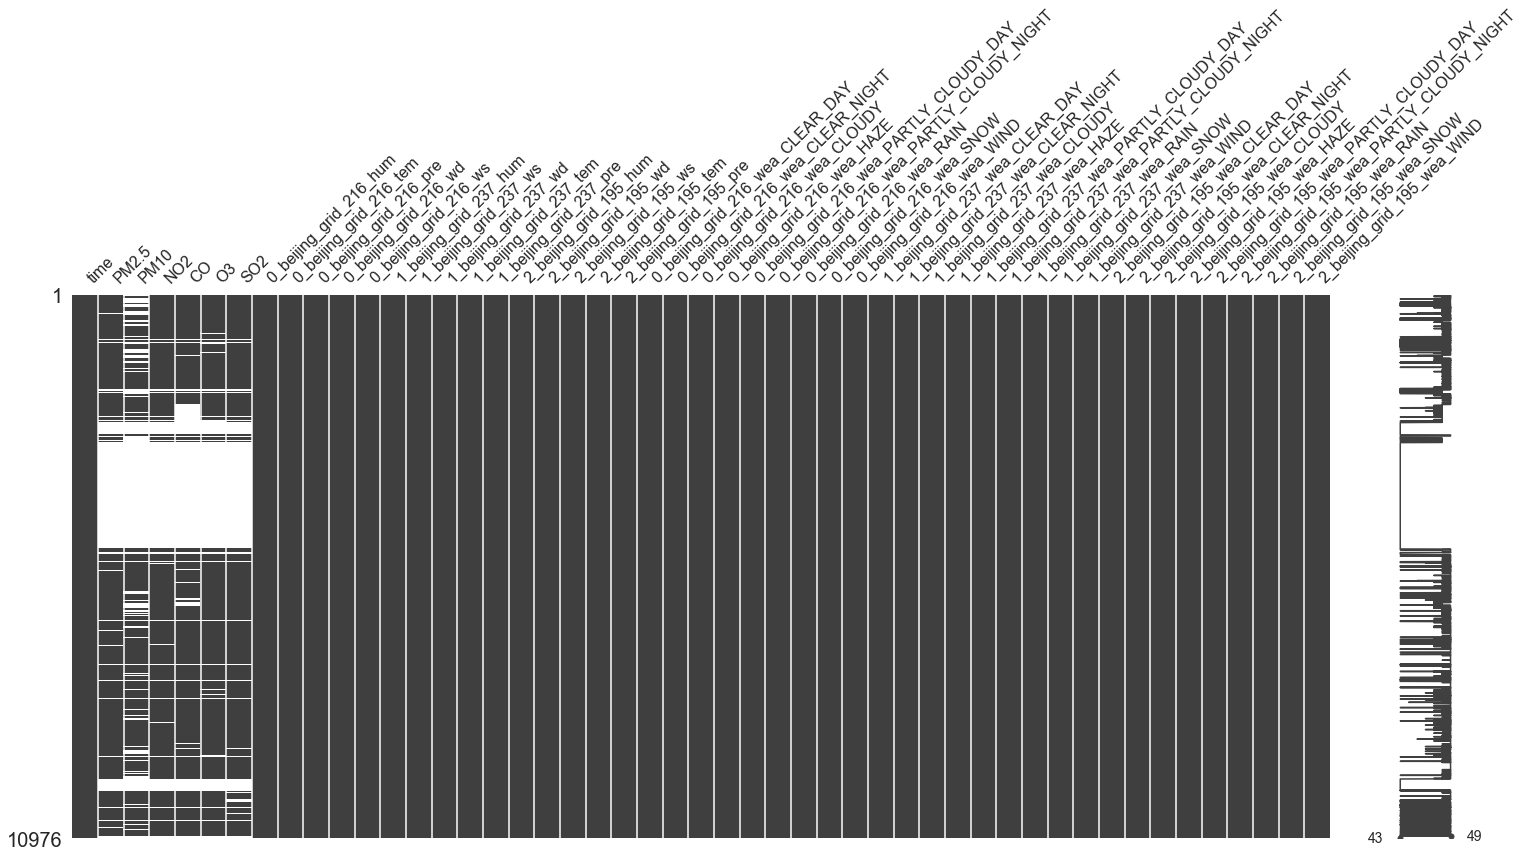

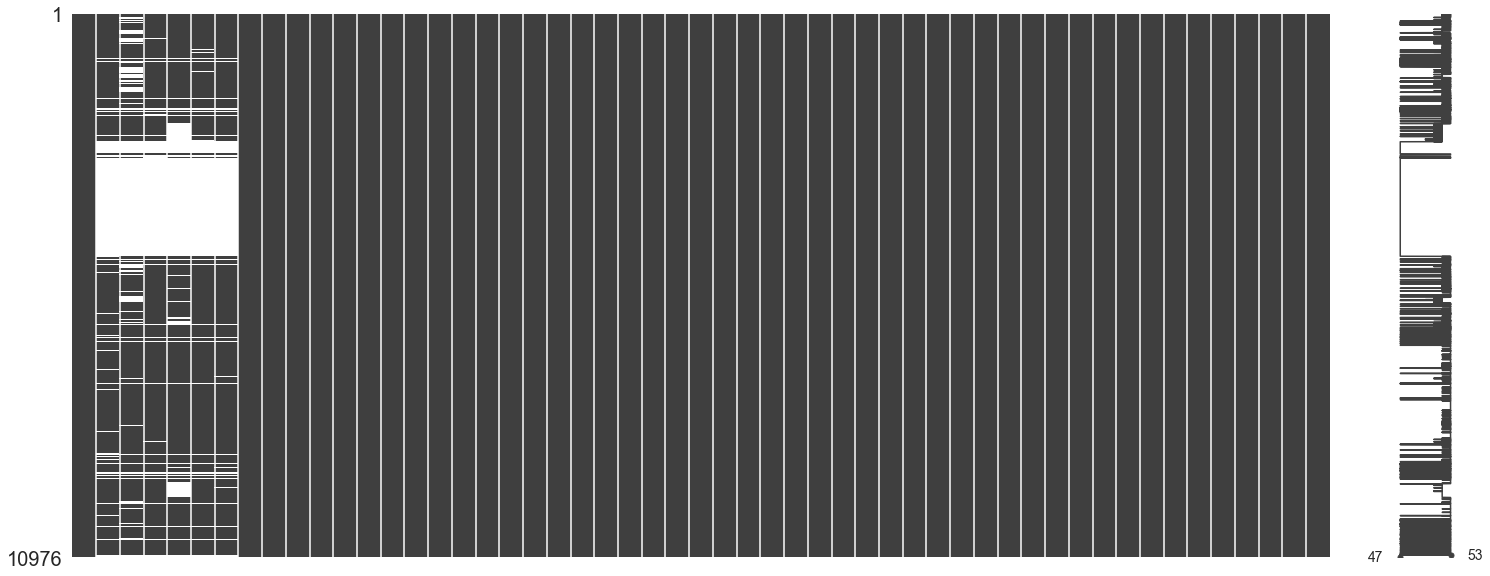

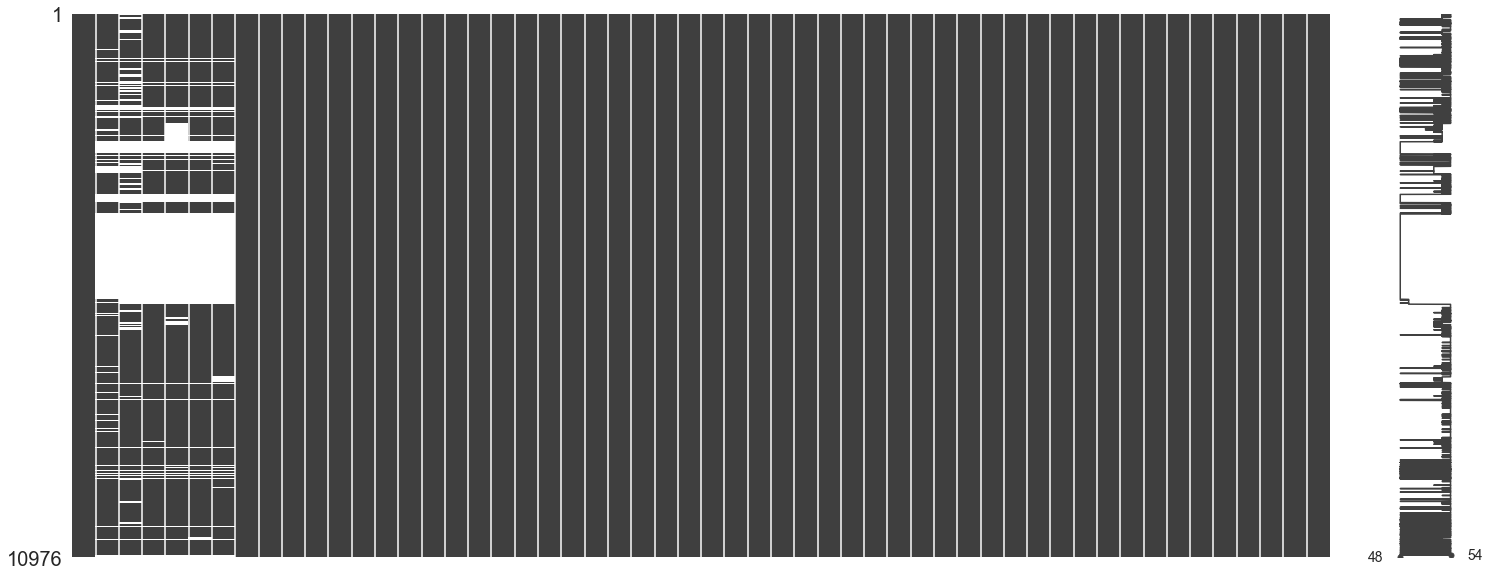

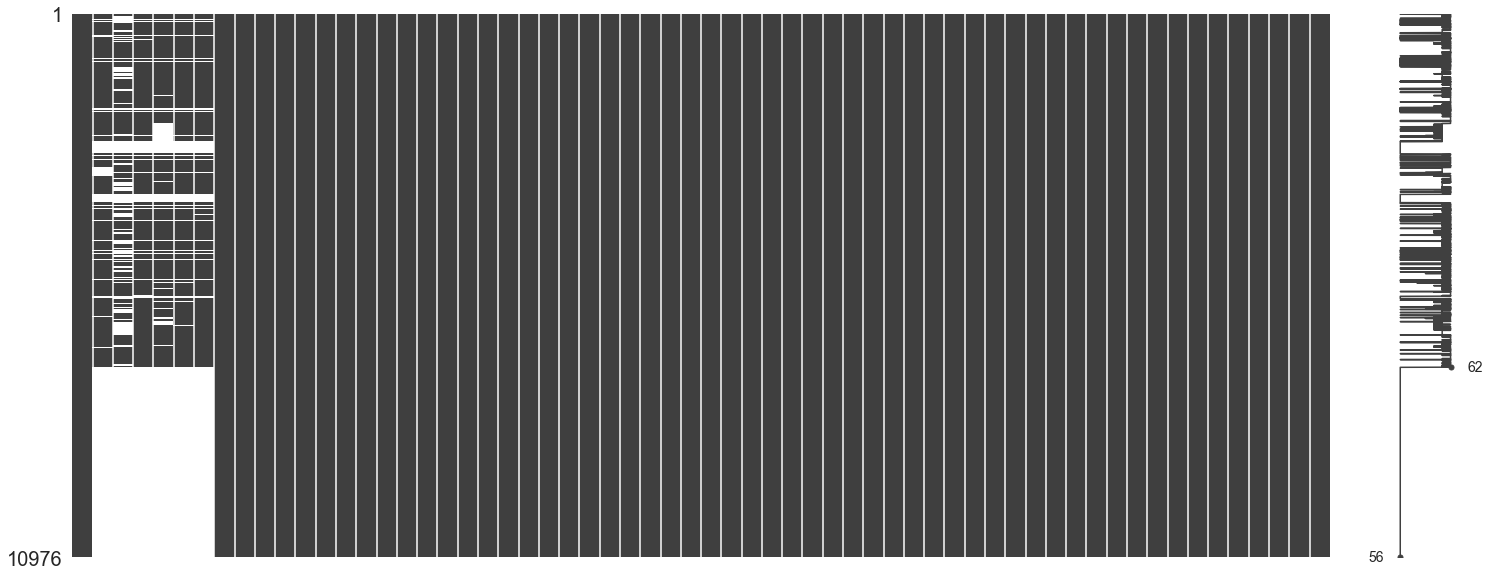

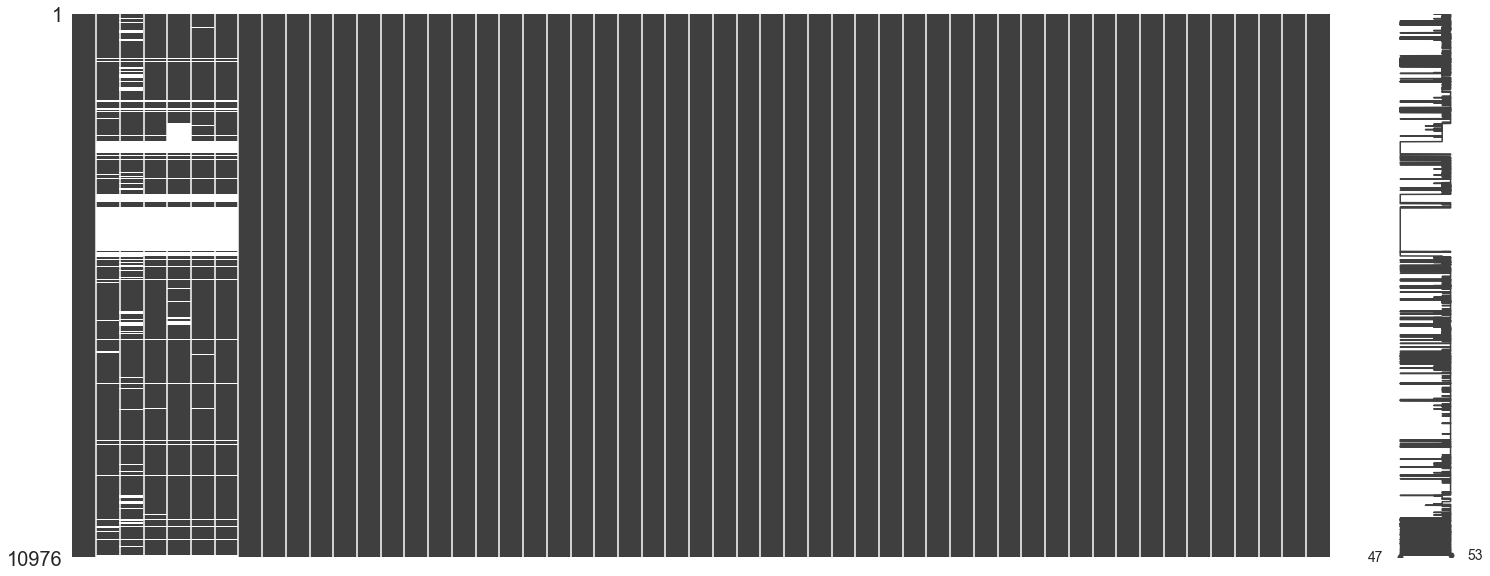

In [39]:
import missingno as msno

# stations which have high missing rate
airQ_special_list = ['liulihe_aq', 'dongsihuan_aq', 'nansanhuan_aq', 'zhiwuyuan_aq', 'tongzhou_aq']
airQ_types = ['PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']

# stations dictionary for LSTM prediction
airQ_lstm_dict = {}
for key, value in airQ_data_dict.items():
    if key not in airQ_special_list:
        airQ_lstm_dict[key] = value

# stations dictionary for Supervised learning
airQ_supervised_dict = {}
for key, value in airQ_data_dict.items():
    if key in airQ_special_list:
        airQ_supervised_dict[key] = value

# 
for i in airQ_special_list:
    print ("======== {} =========".format(i))
    msno.matrix(airQ_data_dict[i])

In [62]:
import ipdb

def lstm(airQ_df, batch_size, n_in, is_predict):
    rmse_dict = {}
    smape_dict = {}
    for air_type in airQ_types[:3]:
        air_type_dict = airQualTypesDataDict(airQ_df)
        X_train, X_val, y_train, y_val, train_index, val_index, scaler = \
            splitTrainValData(air_type_dict[air_type], air_type, n_in, is_predict, 'lstm')
        
        
#         ipdb.set_trace()
        # design network
        model = Sequential()
        hidden_layers = int((X_train.shape[1] * X_train.shape[2]) * 2 / 3)
        model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dense(50, activation='tanh'))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')

        start = time.time()

        # fit network
        ###################### Can change Epochs, Batch size here #######################
        history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_data=(X_val, y_val), 
                            verbose=0, shuffle=False)
        # plot history
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='validation')
        pyplot.legend()
        pyplot.show()

        # make a prediction
        yhat = model.predict(X_val)
        X_val = X_val.reshape((X_val.shape[0], X_val.shape[2]))

        # invert scaling for forecast
#         inv_yhat = concatenate((yhat, X_val[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(yhat.reshape(-1,1))
        inv_yhat = inv_yhat[:,0]

        # invert scaling for actual
#         y_val = y_val.reshape((len(y_val), 1))
#         inv_y = concatenate((y_val, X_val[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(y_val.reshape(-1,1))
        inv_y = inv_y[:,0]

        end = time.time()
        print('This took {} seconds.'.format(end - start))

        # inversed labels dataframe
        y_val_inversed = inv_y
        y_val_inversed_df = pd.DataFrame(y_val_inversed, index=val_index, columns=[air_type])

        pred_inversed = [x if x > 0 else 0 for x in inv_yhat]
        pred_inversed_df = pd.DataFrame(pred_inversed, index=val_index, columns=[air_type])

        # Evaluation result
        rmse_score, smape_score = evaluation(y_val_inversed, pred_inversed)
        rmse_dict[air_type] = rmse_score
        smape_dict[air_type] = smape_score

        # draw line chart
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(val_index, y_val_inversed_df[[air_type]], color='b', label='True')
        ax.plot(val_index, pred_inversed_df[[air_type]], color='orange', label='Prediction')

        ax.set_title(air_type, fontweight="bold", size=16)
        ax.legend(loc="upper right")
        myFmt = DateFormatter("%m %d %H")
        ax.xaxis.set_major_formatter(myFmt)

        ## Rotate date labels automatically
        fig.autofmt_xdate()
        plt.show()
        
    return rmse_dict, smape_dict


### Test

### Analysis

#### Suitable sequence hours for prediction

In [50]:
seq_hours = range(1, 25, 4)
list(seq_hours)

[1, 5, 9, 13, 17, 21]

====================== 1 ===========================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


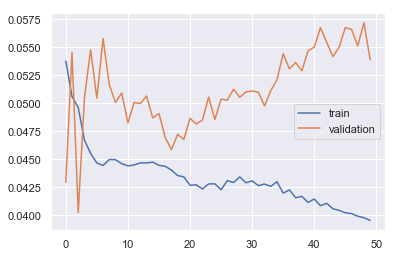

This took 40.33583092689514 seconds.
MSE: 1510.692332251794
RMSE: 38.86762576041652
SMAPE: 0.4818107976176327
R^2 score: 0.723577


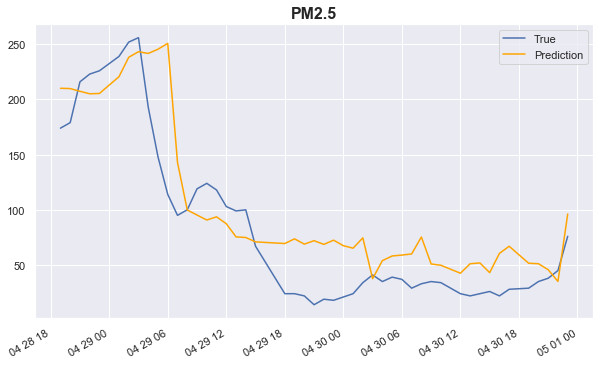

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


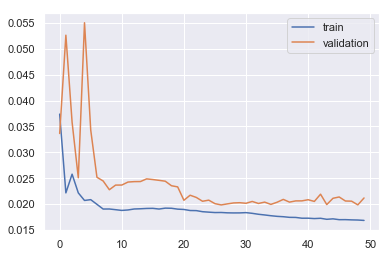

This took 33.65437293052673 seconds.
MSE: 3169.146899398716
RMSE: 56.295176519829084
SMAPE: 0.4479497843502611
R^2 score: 0.274303


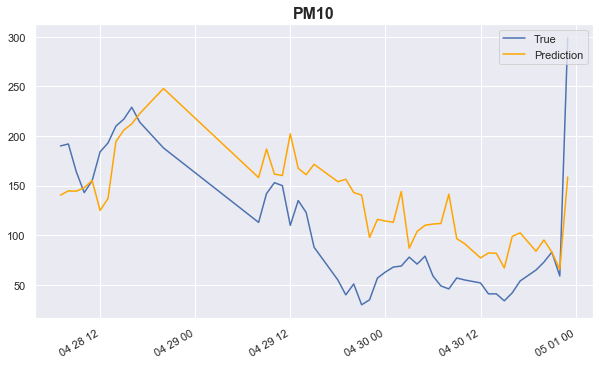

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


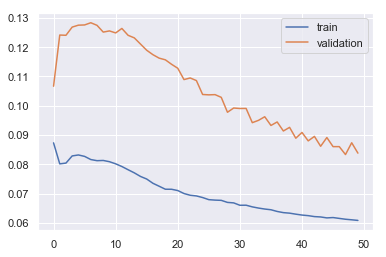

This took 39.147162199020386 seconds.
MSE: 1363.5396010246434
RMSE: 36.92613709860054
SMAPE: 0.5861714299869796
R^2 score: 0.577823


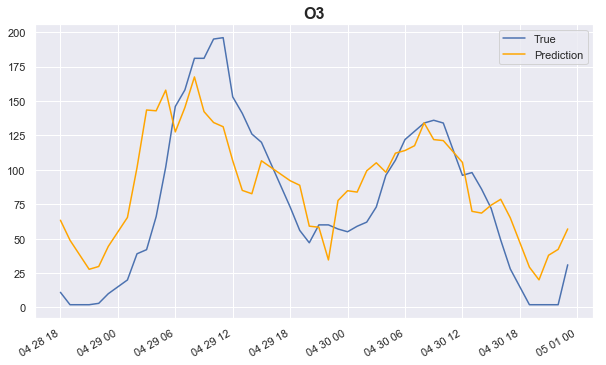

====================== 3 ===========================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


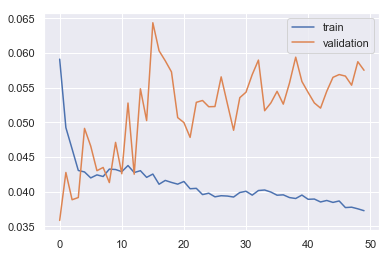

This took 45.12597608566284 seconds.
MSE: 1605.4132189500187
RMSE: 40.06760810118342
SMAPE: 0.5130442596133135
R^2 score: 0.706246


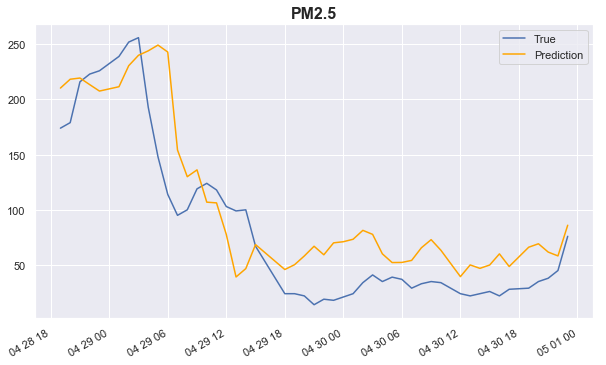

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


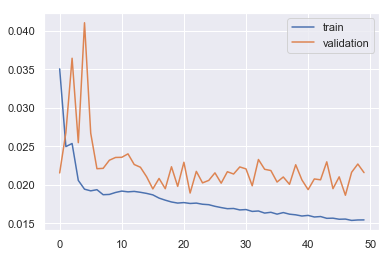

This took 39.95606803894043 seconds.
MSE: 4070.726426832897
RMSE: 63.8022446849082
SMAPE: 0.43493181408088394
R^2 score: 0.067852


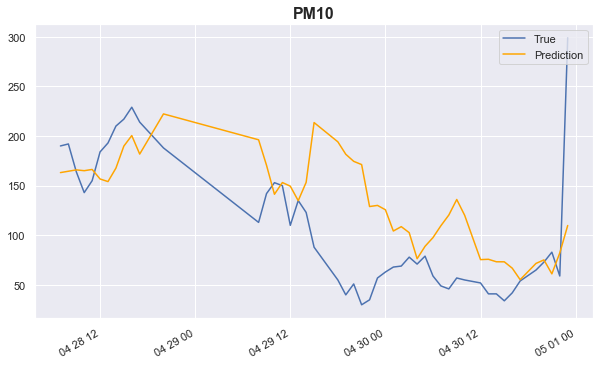

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


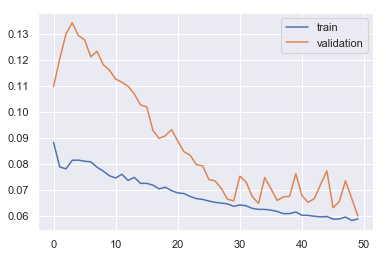

This took 48.31138610839844 seconds.
MSE: 796.3778887930426
RMSE: 28.2201681212753
SMAPE: 0.47938307806732344
R^2 score: 0.753427


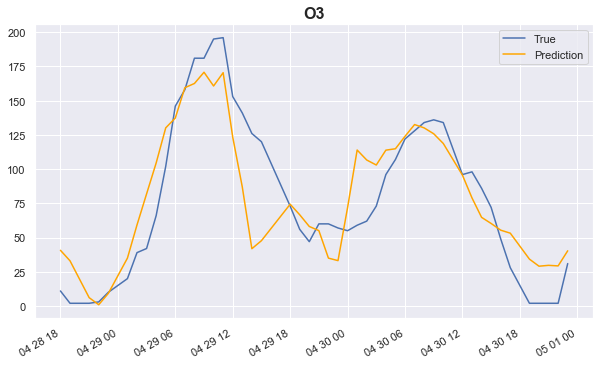

====================== 6 ===========================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


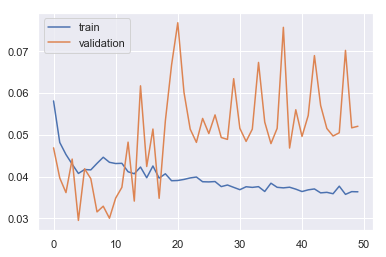

This took 55.70953989028931 seconds.
MSE: 1274.5993408321494
RMSE: 35.70153135136012
SMAPE: 0.45375383032218225
R^2 score: 0.766777


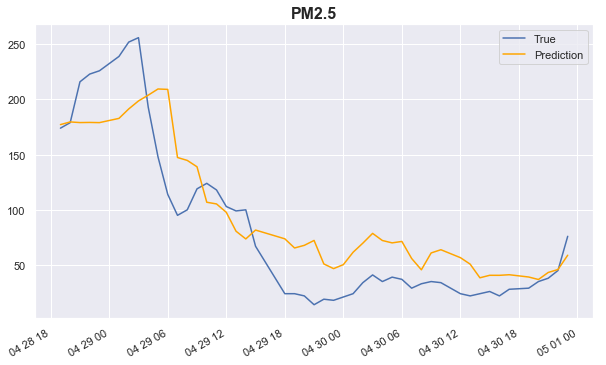

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


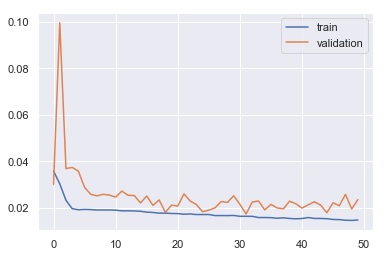

This took 47.43073797225952 seconds.
MSE: 4199.181394097571
RMSE: 64.8010909946551
SMAPE: 0.4768701943150129
R^2 score: 0.038438


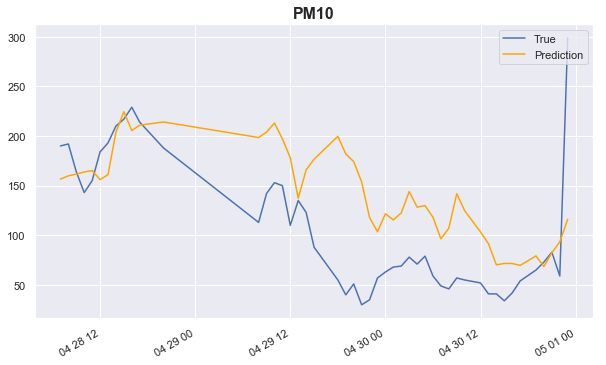

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


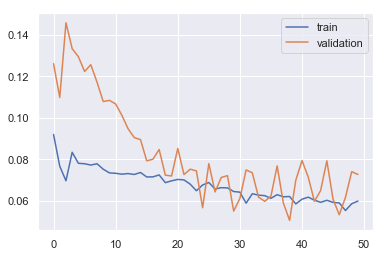

This took 56.54652690887451 seconds.
MSE: 1248.7664838449566
RMSE: 35.33789020081641
SMAPE: 0.506798521793173
R^2 score: 0.613359


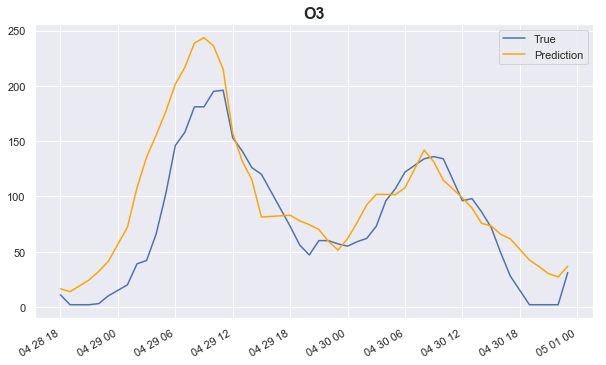

====================== 9 ===========================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


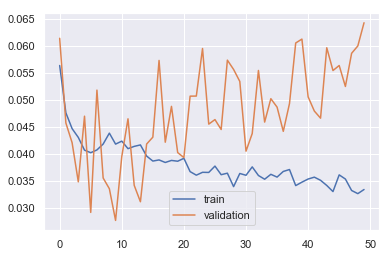

This took 65.28161787986755 seconds.
MSE: 1984.0080535548539
RMSE: 44.54220530637043
SMAPE: 0.5511979525781477
R^2 score: 0.636971


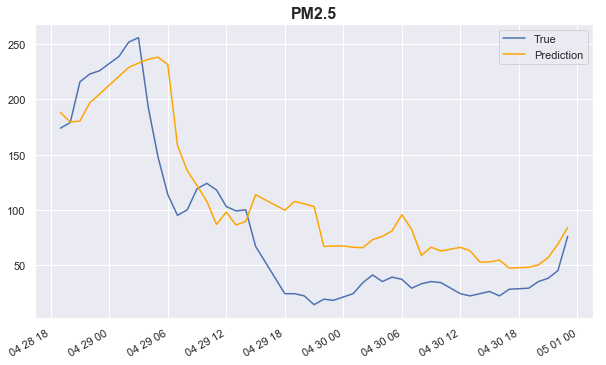

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


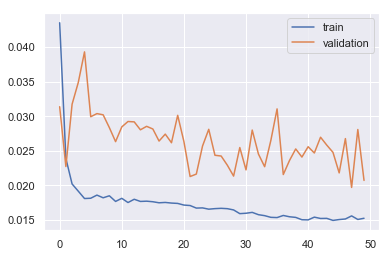

This took 55.81919598579407 seconds.
MSE: 3159.479733732831
RMSE: 56.20924953895783
SMAPE: 0.43520589642295865
R^2 score: 0.276517


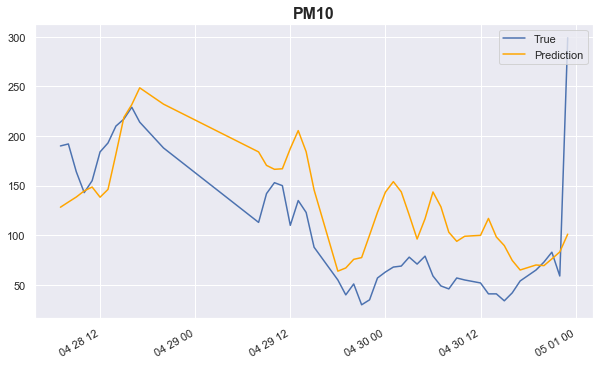

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


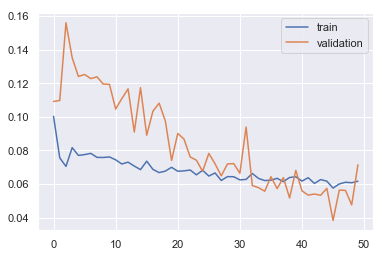

This took 64.4758780002594 seconds.
MSE: 1088.1009174651745
RMSE: 32.986374724500635
SMAPE: 0.5253499135006067
R^2 score: 0.663104


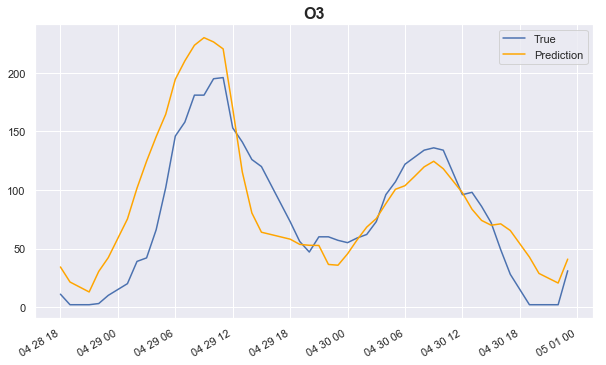

====================== 12 ===========================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


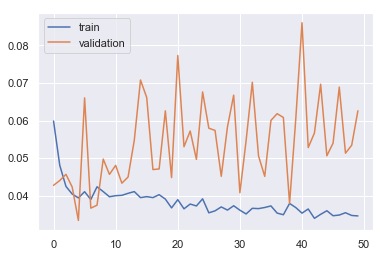

This took 74.58992409706116 seconds.
MSE: 2249.4397030919326
RMSE: 47.42825848681282
SMAPE: 0.47861065594380064
R^2 score: 0.588403


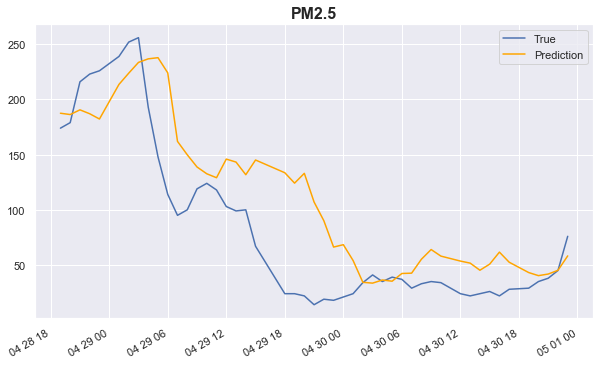

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


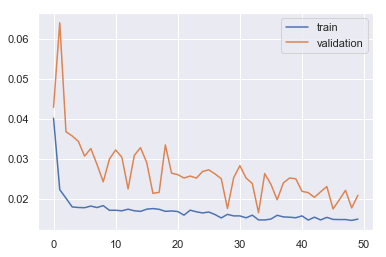

This took 64.00786113739014 seconds.
MSE: 3649.6205594422804
RMSE: 60.412089513956396
SMAPE: 0.41644932994211664
R^2 score: 0.164280


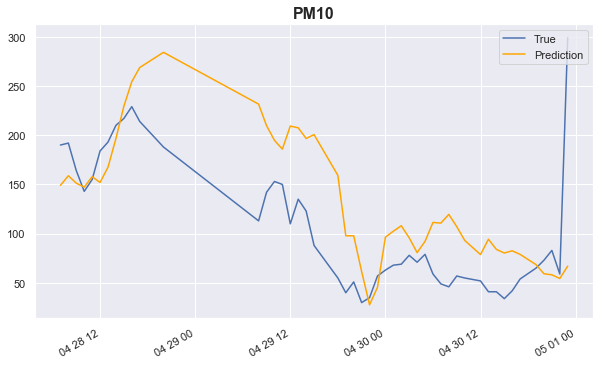

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


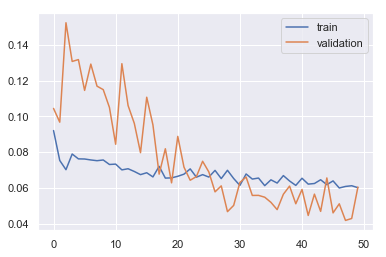

This took 74.84227013587952 seconds.
MSE: 838.6696685502264
RMSE: 28.95979400047981
SMAPE: 0.5558604746876227
R^2 score: 0.740332


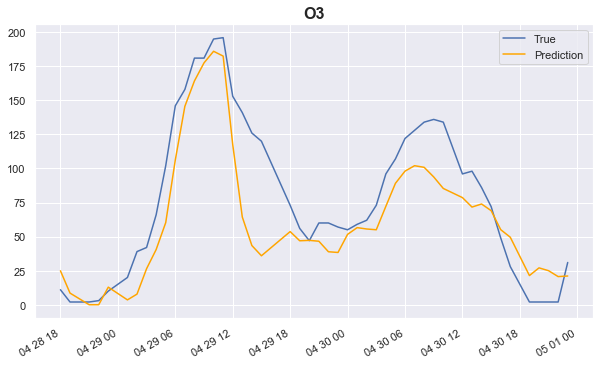

====================== 15 ===========================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


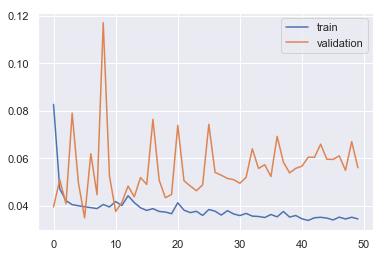

This took 79.79647302627563 seconds.
MSE: 2137.4455914568875
RMSE: 46.2325166031105
SMAPE: 0.45709632047303633
R^2 score: 0.608896


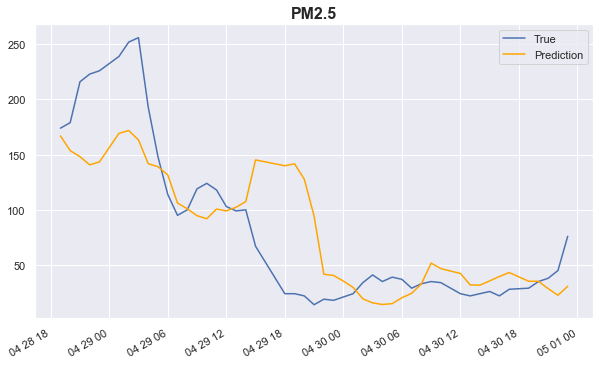

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


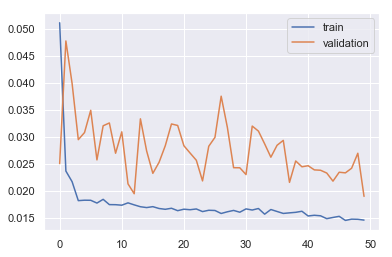

This took 68.5758101940155 seconds.
MSE: 3012.088477020205
RMSE: 54.88249700059396
SMAPE: 0.40390173288502135
R^2 score: 0.310268


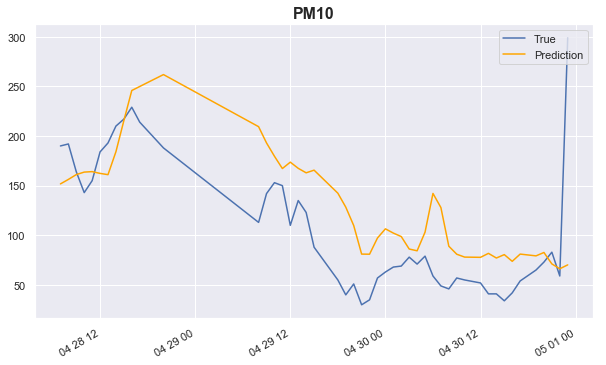

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


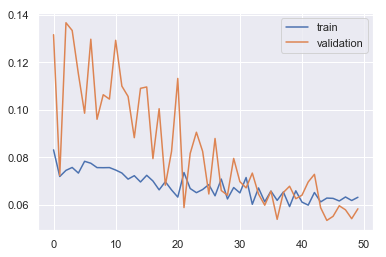

This took 79.42455220222473 seconds.
MSE: 683.1047171587621
RMSE: 26.13627205931944
SMAPE: 0.48317171878166487
R^2 score: 0.788498


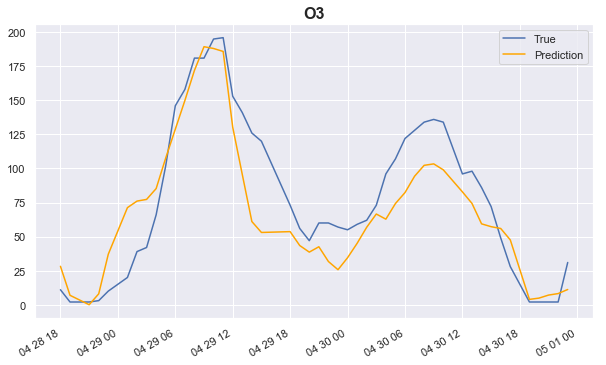

====================== 18 ===========================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


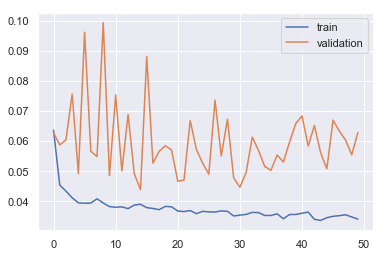

This took 94.19907593727112 seconds.
MSE: 2427.4248538951083
RMSE: 49.268903518295474
SMAPE: 0.4724704416102199
R^2 score: 0.555836


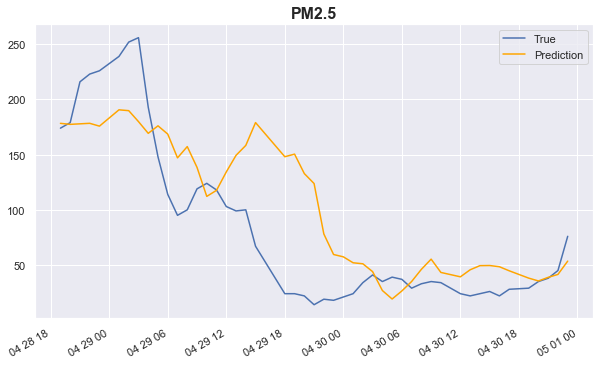

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


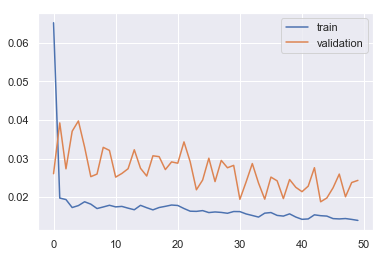

This took 77.49365997314453 seconds.
MSE: 4792.2598319345125
RMSE: 69.22614991413658
SMAPE: 0.4633000099336171
R^2 score: -0.097370


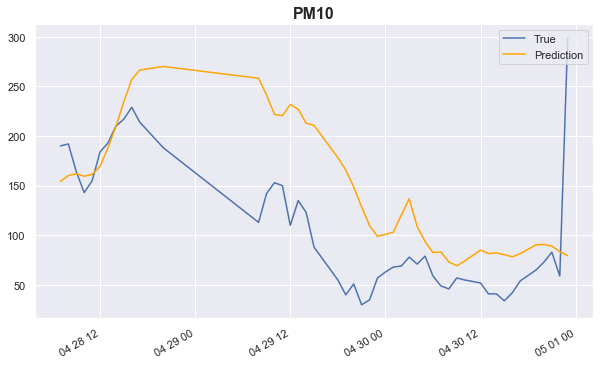

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


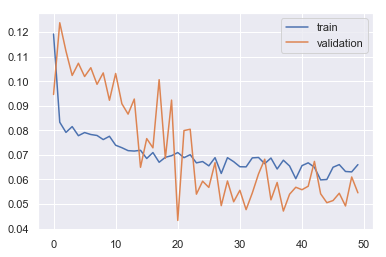

This took 95.15339994430542 seconds.
MSE: 524.1973566694397
RMSE: 22.89535666176528
SMAPE: 0.5305757600985942
R^2 score: 0.837699


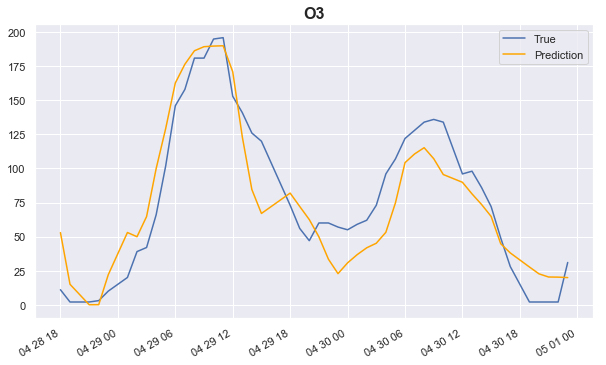

====================== 21 ===========================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


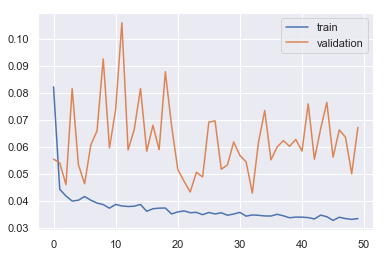

This took 104.24985694885254 seconds.
MSE: 2529.346606646541
RMSE: 50.29260986115695
SMAPE: 0.4795551625246031
R^2 score: 0.537187


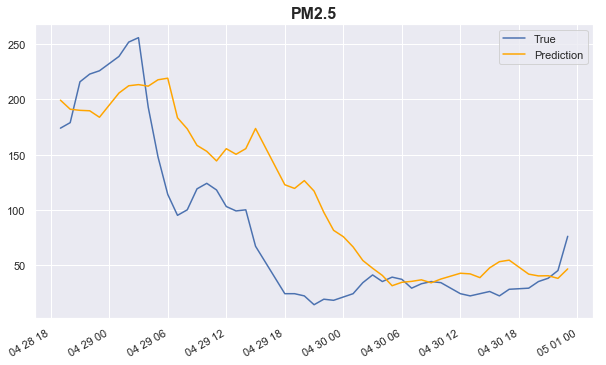

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


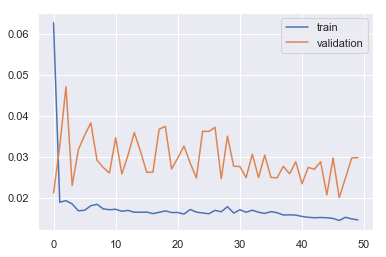

This took 86.28090500831604 seconds.
MSE: 7193.811956076967
RMSE: 84.81634250589309
SMAPE: 0.5195683555467693
R^2 score: -0.647297


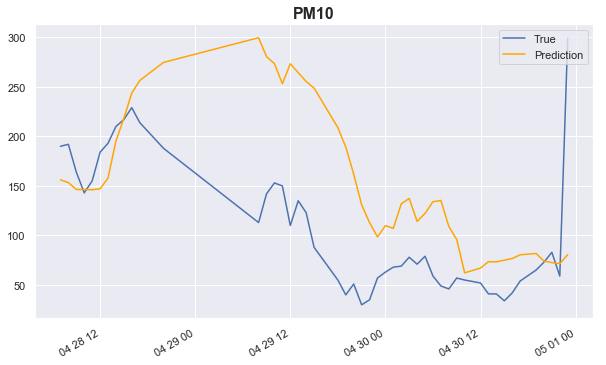

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


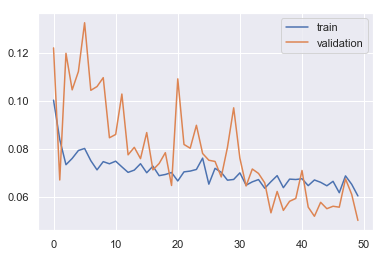

This took 108.26450395584106 seconds.
MSE: 538.4906345991866
RMSE: 23.20540097906491
SMAPE: 0.4485799761052304
R^2 score: 0.833273


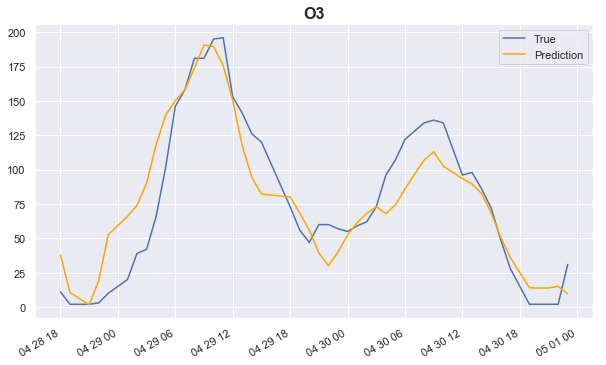

====================== 24 ===========================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


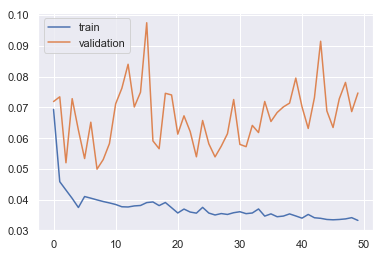

This took 108.86129808425903 seconds.
MSE: 3357.7875833942303
RMSE: 57.94641993595661
SMAPE: 0.5846644851868521
R^2 score: 0.385601


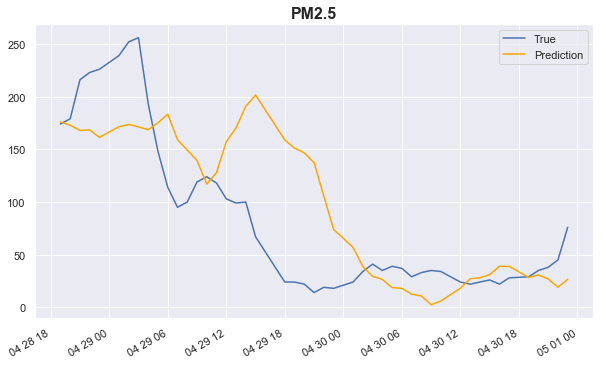

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


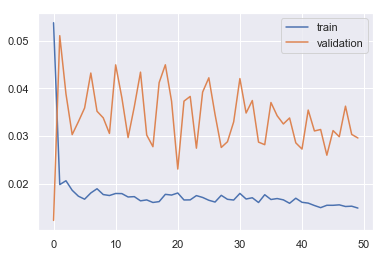

This took 91.74747204780579 seconds.
MSE: 7457.645505911471
RMSE: 86.3576603777075
SMAPE: 0.5034106899429868
R^2 score: -0.707712


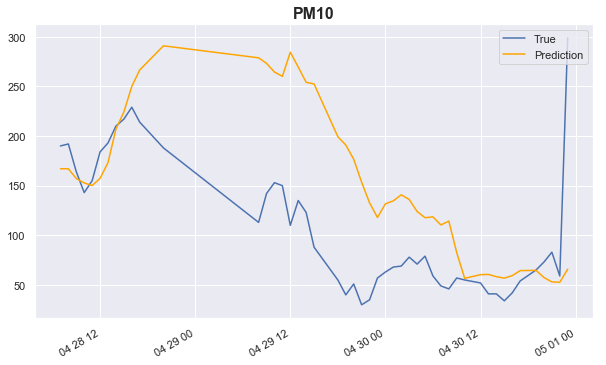

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


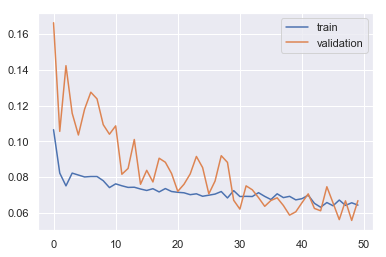

This took 108.10799813270569 seconds.
MSE: 944.5027779153097
RMSE: 30.732763915979145
SMAPE: 0.5240129326954395
R^2 score: 0.707564


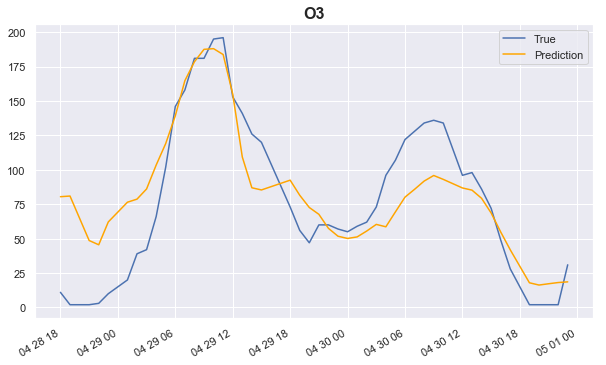

In [64]:
# make a comparison of the different sequence hours for prediction
o_3 = {'rmse': [], 'smape': []}
pm25 = {'rmse': [], 'smape': []}
pm10 = {'rmse': [], 'smape': []}
seq_hours = [1, 3, 6, 9, 12, 15, 18, 21, 24]

for i in seq_hours:
    print ("====================== {} ===========================".format(i))
    rmse_dict, smape_dict = lstm(airQ_data_dict['aotizhongxin_aq'], 80, i, False)
    
    # O3
    o_3['rmse'].append(rmse_dict['O3'])
    o_3['smape'].append(smape_dict['O3'])
    
    # PM2.5
    pm25['rmse'].append(rmse_dict['PM2.5'])
    pm25['smape'].append(smape_dict['PM2.5'])
    
    # PM10
    pm10['rmse'].append(rmse_dict['PM10'])
    pm10['smape'].append(smape_dict['PM10'])
    

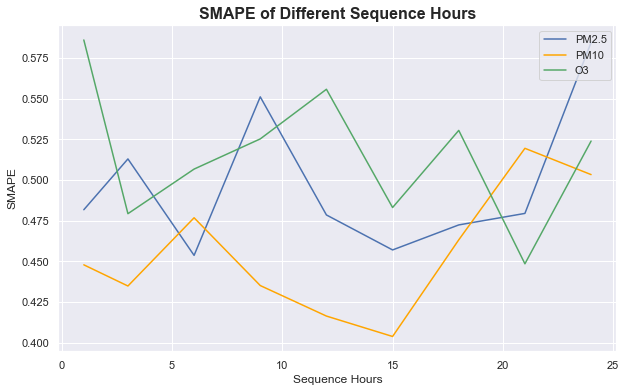

In [65]:
# PM2.5
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(seq_hours, pm25['smape'], color='b', label='PM2.5')
ax.plot(seq_hours, pm10['smape'], color='orange', label='PM10')
ax.plot(seq_hours, o_3['smape'], color='g', label='O3')

ax.set_title('SMAPE of Different Sequence Hours', fontweight="bold", size=16)
ax.legend(loc="upper right")

plt.xlabel('Sequence Hours')
plt.ylabel('SMAPE')
plt.show()

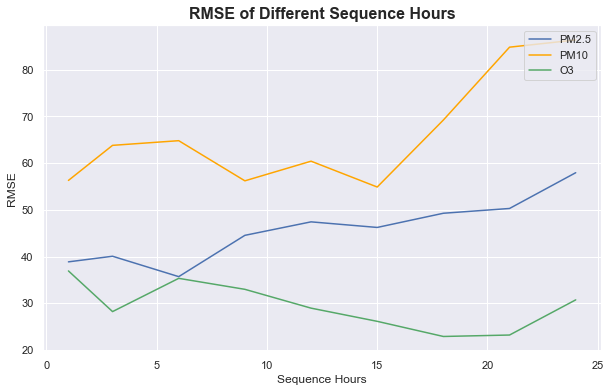

In [66]:
# PM2.5 RMSE
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(seq_hours, pm25['rmse'], color='b', label='PM2.5')
ax.plot(seq_hours, pm10['rmse'], color='orange', label='PM10')
ax.plot(seq_hours, o_3['rmse'], color='g', label='O3')

ax.set_title('RMSE of Different Sequence Hours', fontweight="bold", size=16)
ax.legend(loc="upper right")

plt.xlabel('Sequence Hours')
plt.ylabel('RMSE')
plt.show()